In [1]:
from jax import numpy as jnp, random
from modax.data.kdv import doublesoliton
import jax
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import ARDRegression

import numpy as np

In [2]:
# Making data

key = random.PRNGKey(0)
noise = 0.2

# Making data
x = jnp.linspace(-6, 7, 50)
t = jnp.linspace(0.1, 3.0, 40)
t_grid, x_grid = jnp.meshgrid(t, x, indexing="ij")
y = doublesoliton(x_grid, t_grid, c=[5.0, 2.0], x0=[-5.0, 0.0])

X = jnp.concatenate([t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)], axis=1)
y_noisy = y + noise * jnp.std(y) * random.normal(key, y.shape)

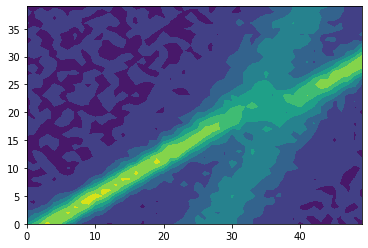

In [3]:
plt.contourf(y_noisy)

In [4]:
U, S, V = jnp.linalg.svd(y_noisy, full_matrices=False)

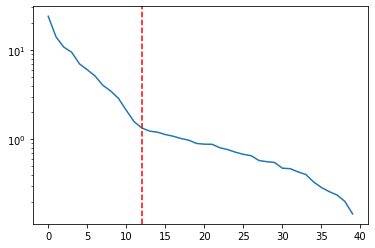

In [5]:
plt.semilogy(S)
plt.axvline(12, color='r', linestyle='--')

In [6]:
# Denoising with SVD
S_dom = jnp.diag(jax.ops.index_update(S, jax.ops.index[12:], 0))
y_denoised = (U @ S_dom @ V)

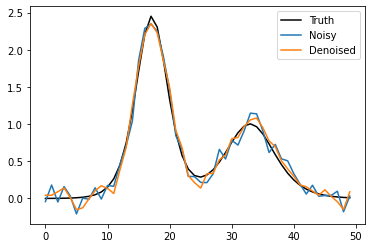

In [7]:
frame = 10
plt.plot(y[frame], 'k', label='Truth')
plt.plot(y_noisy[frame], label='Noisy')
plt.plot(y_denoised[frame], label='Denoised')

plt.legend()

In [8]:
# Calculating splines 
splines = jnp.stack([jnp.stack([UnivariateSpline(x, yi, k=5, s=0).derivatives(xi) for xi in x]) for yi in y_denoised])
u = splines[..., 0]

# TIme deriv is gradient of spline
dt = jnp.gradient(u, t[1]-t[0], axis=0).reshape(-1, 1)

# Derivs
derivs = splines[..., 1:-1].reshape(-1, 4)
derivs = jnp.concatenate([jnp.ones((derivs.shape[0], 1)), derivs], axis=1)

# polynomial
poly = jnp.concatenate([jnp.ones((derivs.shape[0], 1)), u.reshape(-1, 1), (u**2).reshape(-1, 1), (u**3).reshape(-1, 1)], axis=1)

# defining theta
theta = (jnp.expand_dims(poly, axis=-1) @ jnp.expand_dims(derivs, axis=-2)).reshape(derivs.shape[0], -1)

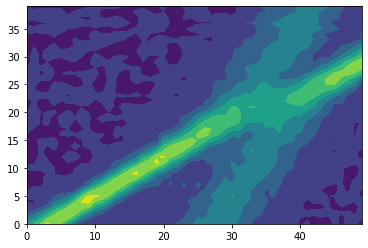

In [9]:
plt.contourf(u)

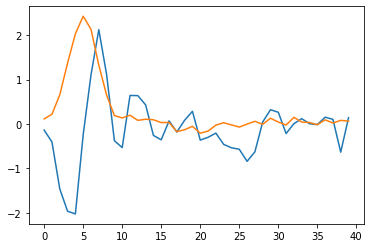

In [10]:
plt.plot((derivs[:, 1].reshape(x_grid.shape)[:, 10]))
plt.plot(u[:, 10])

In [11]:
# SBL results 
SBL = ARDRegression(fit_intercept=False)
SBL.fit(theta, dt.squeeze())

SBL_eq = SBL.coef_

In [12]:
SBL.alpha_

0.37791953152830454

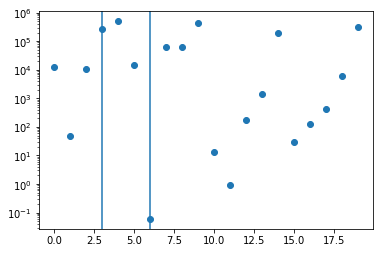

In [13]:
plt.semilogy(SBL.lambda_, 'o')
plt.axvline(3)
plt.axvline(6)

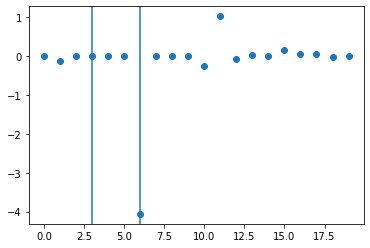

In [14]:
plt.plot(SBL.coef_, 'o')
plt.axvline(3)
plt.axvline(6)

In [24]:
def TrainSTRidge(R, Ut, lam, d_tol, maxit = 25, STR_iters = 10, l0_penalty = None, normalize = 2, split = 0.8):
    """
    This function trains a predictor using STRidge.

    It runs over different values of tolerance and trains predictors on a training set, then evaluates them 
    using a loss function on a holdout set.

    Please note published article has typo.  Loss function used here for model selection evaluates fidelity using 2-norm,
    not squared 2-norm.
    """

    # Split data into 80% training and 20% test, then search for the best tolderance.
    np.random.seed(0) # for consistancy
    n,_ = R.shape
    train = np.random.choice(n, int(n*split), replace = False)
    test = [i for i in np.arange(n) if i not in train]
    TrainR = R[train,:]
    TestR = R[test,:]
    TrainY = Ut[train,:]
    TestY = Ut[test,:]
    D = TrainR.shape[1]       

    # Set up the initial tolerance and l0 penalty
    d_tol = float(d_tol)
    tol = d_tol
    if l0_penalty == None: l0_penalty = 0.001*np.linalg.cond(R)

    # Get the standard least squares estimator
    w = np.zeros((D,1))
    w_best = np.linalg.lstsq(TrainR, TrainY, rcond=None)[0]
    err_best = np.linalg.norm(TestY - TestR.dot(w_best), 2) + l0_penalty*np.count_nonzero(w_best)
    tol_best = 0

    # Now increase tolerance until test performance decreases
    for iter in range(maxit):

        # Get a set of coefficients and error
        w = STRidge(R,Ut,lam,STR_iters,tol,normalize = normalize)
        err = np.linalg.norm(TestY - TestR.dot(w), 2) + l0_penalty*np.count_nonzero(w)

        # Has the accuracy improved?
        if err <= err_best:
            err_best = err
            w_best = w
            tol_best = tol
            tol = tol + d_tol

        else:
            tol = max([0,tol - 2*d_tol])
            d_tol  = 2*d_tol / (maxit - iter)
            tol = tol + d_tol

    return w_best


def STRidge(X0, y, lam, maxit, tol, normalize = 2, print_results = False):
    """
    Sequential Threshold Ridge Regression algorithm for finding (hopefully) sparse 
    approximation to X^{-1}y.  The idea is that this may do better with correlated observables.

    This assumes y is only one column
    """

    n,d = X0.shape
    X = np.zeros((n,d), dtype=np.complex64)
    # First normalize data
    if normalize != 0:
        Mreg = np.zeros((d,1))
        for i in range(0,d):
            Mreg[i] = 1.0/(np.linalg.norm(X0[:,i],normalize))
            X[:,i] = Mreg[i]*X0[:,i]
    else: X = X0
    
    # Get the standard ridge esitmate
    if lam != 0: w = np.linalg.lstsq(X.T.dot(X) + lam*np.eye(d),X.T.dot(y), rcond=None)[0]
    else: w = np.linalg.lstsq(X,y)[0]
    num_relevant = d
    biginds = np.where( abs(w) > tol)[0]
    
    # Threshold and continue
    for j in range(maxit):

        # Figure out which items to cut out
        smallinds = np.where( abs(w) < tol)[0]
        new_biginds = [i for i in range(d) if i not in smallinds]
            
        # If nothing changes then stop
        if num_relevant == len(new_biginds): break
        else: num_relevant = len(new_biginds)
            
        # Also make sure we didn't just lose all the coefficients
        if len(new_biginds) == 0:
            if j == 0: 
                #if print_results: print "Tolerance too high - all coefficients set below tolerance"
                return w
            else: break
        biginds = new_biginds
        
        # Otherwise get a new guess
        w[smallinds] = 0
        if lam != 0: w[biginds] = np.linalg.lstsq(X[:, biginds].T.dot(X[:, biginds]) + lam*np.eye(len(biginds)),X[:, biginds].T.dot(y), rcond=None)[0]
        else: w[biginds] = np.linalg.lstsq(X[:, biginds],y)[0]

    # Now that we have the sparsity pattern, use standard least squares to get w
    if biginds != []: w[biginds] = np.linalg.lstsq(X[:, biginds],y, rcond=None)[0]
    
    if normalize != 0: return np.multiply(Mreg,w)
    else: return w

In [25]:
TrainSTRidge(theta, dt, lam=1e-2, d_tol=0.001)

<ipython-input-24-ed62bb3486df>:105: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if biginds != []: w[biginds] = np.linalg.lstsq(X[:, biginds],y, rcond=None)[0]


array([[-7.14820350e-02+0.j],
       [-1.45562971e-01+0.j],
       [ 1.12298244e-02+0.j],
       [-3.32334502e-05+0.j],
       [-1.17852448e-04+0.j],
       [ 1.05888879e+00+0.j],
       [-4.32718148e+00+0.j],
       [-1.56565268e-02+0.j],
       [ 1.03460390e-02+0.j],
       [ 5.56758503e-04+0.j],
       [-2.11536009e+00+0.j],
       [ 1.58223960e+00+0.j],
       [-1.93235409e-01+0.j],
       [ 2.24106266e-02+0.j],
       [-1.87671573e-03+0.j],
       [ 9.46130658e-01+0.j],
       [-2.30774539e-01+0.j],
       [ 1.46233902e-01+0.j],
       [-1.78722866e-02+0.j],
       [ 1.16373801e-03+0.j]])